# Presentation of "Learning How To Explain Neural Networks: PatternNet and PatternAttribution"



## Introduction


In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Overview of Explanation Approaches
### What is an explanation

### Functions

### Signals

### Attribution



## Understanding Linear Models


The authors presents a simple linear model where the data $X \in \mathbb{R}^{n\times 2}$ is constructed as follows. Let $y \in \mathbb{R}^n$ be a given set og labels and the _signal_ of the data be $S = y a_s^\intercal$, where $a_s \in \mathbb{R}^2$ is the direction of the signal. Furthermore, let $\epsilon \sim \mathcal{N}(\mu, \sigma^2) \in \mathbb{R}^n$ be noise added to the data as a _distractor_ $D = a_d \epsilon$, where $a_d \in \mathbb{R}^2$ is the direction of the distractor. Then, $X = S + D$.

Note, that to find the $w$ that minimizes the mean squared error (MSE) $\frac{1}{n}||Xw = y||^2_2$, we simply use linear regression and obtain
$$
w = (X^\intercal X)^{-1} X^\intercal y = X^\dagger y
$$

Let's construct the data and find $w$.

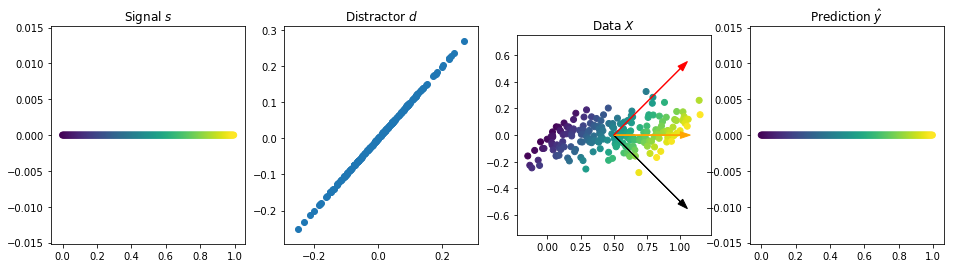

In [65]:
# Construct the data
n       = 200
y       = np.arange(n) / n
a_s     = np.array((1., 0.))
a_d     = np.array((1., 1.))
epsilon = np.random.normal(0, 0.1, size=(n,))

S       = np.outer(y, a_signal)
D       = np.outer(epsilon, a_distract)
X       = signal + distractor

fig, ax = plt.subplots(1, 4, figsize=(16,4))

# Plot signal, distractor and the actual data (signal + distractor)
ax[0].set_title("Signal $s$")
ax[0].scatter(S[:,0], S[:,1], c=ys)
ax[1].set_title("Distractor $d$")
ax[1].scatter(D[:,0], D[:,1])
ax[2].set_title("Data $X$")
ax[2].scatter(X[:,0], X[:,1], c=ys)

# Predict y from X (Linear regression)
w           = np.linalg.pinv(X) @ y

# Draw arrows on the data plot
ax[2].set_ylim(-0.75, 0.75)
ax[2].set_aspect('equal')
ax[2].arrow(0.5,0, *w*0.5,   head_width=.05, color='black')
ax[2].arrow(0.5,0, *a_s*0.5, head_width=.05, color='orange')
ax[2].arrow(0.5,0, *a_d*0.5, head_width=.05, color='red')

y_hat       = X @ w
# print("MSE: ", np.mean((y_hat - y)**2))

ax[3].set_title("Prediction $\hat y$")
ax[3].scatter(y_hat, np.zeros_like(y), c=y)


Some observations about the $X$ and $w$:
1. $w$ and $a_s$ does not point in the same direction
2. $w$ perfectly recovers $y$ but it does not reveal anything about how to extract $s$, $d$, $a_s$ or $a_d$.

$$r_i^{output} = y, \quad r_{j \neq i}^{output} = 0, \quad r^{l-1,i} = \frac{w \odot ( x - x_0)}{ w^\intercal  x}r_i^l$$

In [81]:
# Layer-Wise Relevance Propagation [REF]
# Epsilon rule
Zij   = X * w.reshape((1, 2))
R     = Zij / Zij.sum(1, keepdims=True) * y_hat.reshape((n, 1)) 

print("Relevances for the first 10 samples:")
print(R[:10])

Relevances for the first 10 samples:
[[-0.05095512  0.05095512]
 [ 0.06728341 -0.06228341]
 [-0.14707203  0.15707203]
 [ 0.03893623 -0.02393623]
 [-0.09518223  0.11518223]
 [ 0.08454288 -0.05954288]
 [-0.00110358  0.03110358]
 [ 0.12584887 -0.09084887]
 [ 0.02853113  0.01146887]
 [ 0.04009002  0.00490998]]


## Trying the beast in practice

**Simple Network:**  
We will build a small network with 2 convolutional layers, both followed by a max pooling layer. Then on top of that, we will add two fully connected layers. We will then train the network to classify mnist images.

**Explanations:**  
When we have trained the network, we will then produce some explanations, using different techniques.
Here, we will use the `innvestigate` framework that the authors of the PatternNet article have published.


In [ ]:
import sys
import os.path
import imp

import keras
import keras.backend
import keras.layers
import keras.models
from keras.models import model_from_json
import keras.utils

import innvestigate
import innvestigate.applications.imagenet
import innvestigate.layers as ilayers
import innvestigate.utils as iutils
import innvestigate.utils.keras as kutils
import innvestigate.utils.keras.checks as kchecks
import innvestigate.utils.keras.graph as kgraph

eutils = imp.load_source('utils', 'innvestigate/examples/utils.py')
imgnetutils = imp.load_source('utils_imagenet', 'innvestigate/examples/utils_imagenet.py')

# Load the model definition.
tmp = getattr(innvestigate.applications.imagenet, os.environ.get("NETWORKNAME", "vgg16"))
net = tmp(load_weights=True, load_patterns="relu")

# Build the model.
model = keras.models.Model(inputs=net["in"], outputs=net["sm_out"])
model.compile(optimizer="adam", loss="categorical_crossentropy")

# Handle input depending on model and backend.
channels_first = keras.backend.image_data_format() == "channels_first"
if channels_first:
    print("CHANNEL FIRST ")
    channel_axis = 1
else:
    print("NOT CHANNEL FIRST ")
    channel_axis = 3
color_conversion = "BGRtoRGB" if net["color_coding"] == "BGR" else None

model_wo_sm = iutils.keras.graph.model_wo_softmax(model)
images, label_to_class_name = eutils.get_imagenet_data(net["image_shape"][0])
if not len(images):
    raise Exception("Please download images")

n_imgs = 4
figs, ax = plot.subplots(n_imgs, 5, figsize=(16,5))

lrp_e = innvestigate.create_analyzer("lrp.epsilon", model_wo_sm)
lrp_zp = innvestigate.create_analyzer("lrp.z_plus", model_wo_sm)

lrp_pn = innvestigate.create_analyzer("lrp.z_plus", model_wo_sm)
# TODO FIT PN ANALYZER

for i in range(n_imgs):
    # Choose a sample image and add batch axis
    image    = images[i][0][None, :, :, :]

    #Preprocess it for VGG16
    image_pp = imgnetutils.preprocess(image, net)

    # Create analysis
    a_e      = lrp_e.analyze(image_pp)
    a_zp     = lrp_zp.analyze(image_pp)
    a_pn     = lrp_pn.analyze(image_pp) 

    # Post process images
    a_e  = imgnetutils.postprocess(a_e, color_conversion, channels_first)
    a_zp = imgnetutils.postprocess(a_zp, color_conversion, channels_first)
    a_zp = imgnetutils.postprocess(a_pn, color_conversion, channels_first)

    ax[i][0].imshow(image[0]/255)
    if i == 0: ax[i][0].set_title("Input")

    ax[i][1].imshow(imgnetutils.heatmap(a_e)[0])
    if i == 0: ax[i][1].set_title("Epsilon rule")
    
    ax[i][2].imshow(imgnetutils.heatmap(a_zp)[0])
    if i == 0: ax[i][2].set_title("$Z^+$-rule")
    
    ax[i][3].imshow(imgnetutils.heatmap(r_z)[0])
    if i == 0: ax[i][3].set_title("PatternAttribution")

plot.savefig('Figure1.png')
plot.show()
